Train with core terms only

In [1]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_without_test4.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_core_terms_with_embeddings.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_core_ada_embedding'] for item in balanced if item['cwe'] != 'None'])
test = np.array([item['cwe'] for item in balanced if item['cwe'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_core_ada_embedding'] for item in unbalanced if item['cwe'] != 'None'])
y_test = np.array([item['cwe'] for item in unbalanced if item['cwe'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train.joblib')

Epoch 1/40
260/260 [==============================] - 0s 1ms/step loss: 1.8929 - acc
Epoch 1 - F1 Score: 0.5673
Saved best model
[0.5673132698789645]
2336/2336 [==============================] - 7s 3ms/step - loss: 1.8884 - accuracy: 0.5006 - val_loss: 1.4523 - val_accuracy: 0.5988
Epoch 2/40
260/260 [==============================] - 0s 2ms/step loss: 1.3777 
Epoch 2 - F1 Score: 0.6085
Saved best model
[0.5673132698789645, 0.6084945272806066]
2336/2336 [==============================] - 7s 3ms/step - loss: 1.3773 - accuracy: 0.6180 - val_loss: 1.3351 - val_accuracy: 0.6294
Epoch 3/40
260/260 [==============================] - 0s 1ms/step loss: 1.2907 - 
Epoch 3 - F1 Score: 0.6258
Saved best model
[0.5673132698789645, 0.6084945272806066, 0.6257839526467732]
2336/2336 [==============================] - 8s 3ms/step - loss: 1.2908 - accuracy: 0.6398 - val_loss: 1.2779 - val_accuracy: 0.6452
Epoch 4/40
260/260 [==============================] - 1s 2ms/step loss: 1.2
Epoch 4 - F1 Score: 0.6

['label_encoder_train.joblib']

Inference core terms

In [12]:
import pickle
import numpy as np
from sklearn.metrics import classification_report
import joblib
from sklearn.preprocessing import LabelEncoder
# Save the best model
with open('test_core_terms_with_embeddings.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

X_test = np.array([item['cve_core_ada_embedding'] for item in unbalanced if item['cwe'] != 'None'])
y_test = np.array([item['cwe'] for item in unbalanced if item['cwe'] != 'None'])

best_model=joblib.load('best_model.joblib')
label_encoder_train=joblib.load('label_encoder_train.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

444/444 [==============================] - 1s 3ms/step
Classification Report:
               precision    recall  f1-score   support

         119     0.7261    0.5327    0.6146      1070
         120     0.3075    0.7092    0.4290       196
         125     0.8136    0.7876    0.8004       532
         134     0.7826    0.9474    0.8571        19
         189     0.5422    0.7563    0.6316       119
         190     0.6786    0.7600    0.7170       200
          20     0.4630    0.2160    0.2946       810
         200     0.5823    0.4678    0.5188       590
         203     0.4872    0.7037    0.5758        27
          22     0.8857    0.8822    0.8839       518
         254     0.0870    0.0588    0.0702        34
         255     0.3167    0.2836    0.2992        67
         264     0.4098    0.4831    0.4434       503
         269     0.3087    0.4340    0.3608       106
         276     0.2464    0.2656    0.2556        64
         284     0.3636    0.1626    0.2247       123
  

In [8]:
import joblib# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc/X_test.joblib')
y_test = joblib.load('reproduc/y_test.joblib')
unbalanced = joblib.load('reproduc/unbalanced.joblib')
y_pred_original = joblib.load('reproduc/y_pred_original.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 68 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)

Total Sentences Below Short Threshold: 1546
Misclassified Short Sentences: 433
Percentage of Misclassified Short Sentences: 28.007761966364814
Total Sentences Above Long Threshold: 1312
Misclassified Long Sentences: 611
Percentage of Misclassified Long Sentences: 46.57012195121951


In [9]:
# Initialize counters for misclassified sentences
import joblib
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)


Total Sentences: 14202
Misclassified Sentences: 4877
Percentage of Misclassified Sentences: 34.34023376989156


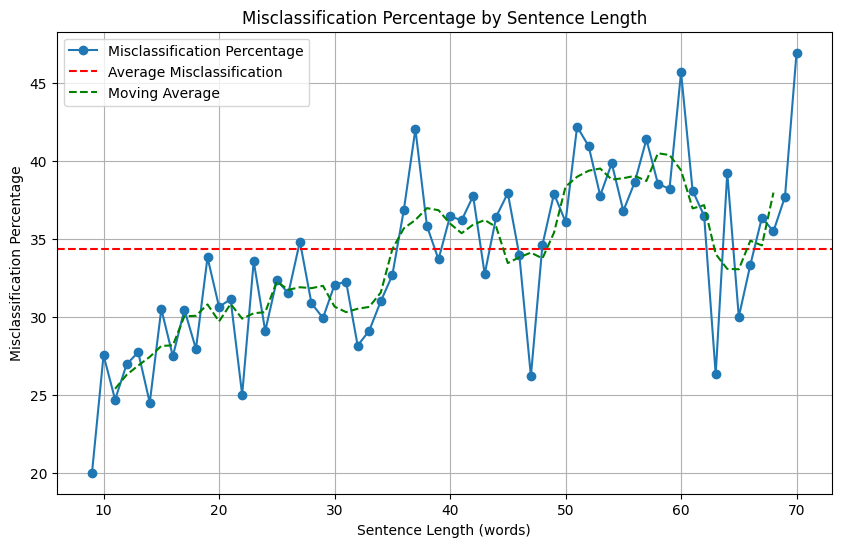

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 70 or description_words < 9:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_without_test4.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_core_terms_with_embeddings.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_core_ada_embedding'] for item in balanced if item['cwe_class'] != 'None'])
test = np.array([item['cwe_class'] for item in balanced if item['cwe_class'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_core_ada_embedding'] for item in unbalanced if item['cwe_class'] != 'None'])
y_test = np.array([item['cwe_class'] for item in unbalanced if item['cwe_class'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes_class.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train_class.joblib')

Epoch 1/40
227/227 [==============================] - 0s 1ms/step loss: 1.1387 - acc
Epoch 1 - F1 Score: 0.7591
Saved best model
[0.7591196725734888]
2036/2036 [==============================] - 10s 4ms/step - loss: 1.1367 - accuracy: 0.6899 - val_loss: 0.8409 - val_accuracy: 0.7711
Epoch 2/40
227/227 [==============================] - 0s 1ms/step loss: 0.7969 - ac
Epoch 2 - F1 Score: 0.7858
Saved best model
[0.7591196725734888, 0.7858005398728388]
2036/2036 [==============================] - 6s 3ms/step - loss: 0.7972 - accuracy: 0.7804 - val_loss: 0.7694 - val_accuracy: 0.7919
Epoch 3/40
227/227 [==============================] - 0s 2ms/step loss: 0.7462 - 
Epoch 3 - F1 Score: 0.7886
Saved best model
[0.7591196725734888, 0.7858005398728388, 0.7886138950652154]
2036/2036 [==============================] - 8s 4ms/step - loss: 0.7462 - accuracy: 0.7924 - val_loss: 0.7503 - val_accuracy: 0.7946
Epoch 4/40
227/227 [==============================] - 0s 1ms/step loss: 0.7184 - accu
Epoch 4 

['label_encoder_train_class.joblib']

In [10]:
# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc2/X_test.joblib')
y_test = joblib.load('reproduc2/y_test.joblib')
y_pred_original = joblib.load('reproduc2/y_pred_original.joblib')
unbalanced = joblib.load('reproduc2/unbalanced.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 64 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)


Total Sentences Below Short Threshold: 1430
Misclassified Short Sentences: 289
Percentage of Misclassified Short Sentences: 20.20979020979021
Total Sentences Above Long Threshold: 1412
Misclassified Long Sentences: 277
Percentage of Misclassified Long Sentences: 19.61756373937677


In [11]:
# Initialize counters for misclassified sentences
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)


Total Sentences: 12845
Misclassified Sentences: 2537
Percentage of Misclassified Sentences: 19.750875827170105


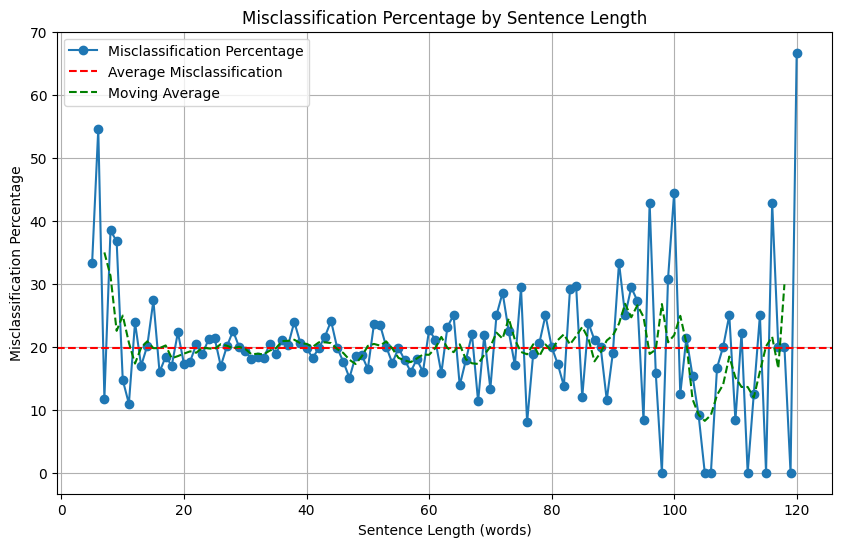

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 120:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_f1 = 0.0
        self.best_model = None
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=1)
        f1 = f1_score(self.y_val, y_val_pred, average='weighted')
        self.f1_scores.append(f1)
        

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_model = self.model
            print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}")
            print("Saved best model")
            print(self.f1_scores)

with open('train_without_test4_high_abstr.pickle', 'rb') as f1:
    balanced = pickle.load(f1)

with open('test_core_terms_with_embeddings_high_abstr.pickle', 'rb') as f2:
    unbalanced = pickle.load(f2)

train = np.array([item['cve_core_ada_embedding'] for item in balanced if item['cwe_high_abstraction'] != 'None'])
test = np.array([item['cwe_high_abstraction'] for item in balanced if item['cwe_high_abstraction'] != 'None'])
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(train,test,test_size=0.1,random_state=42)

X_test = np.array([item['cve_core_ada_embedding'] for item in unbalanced if item['cwe_high_abstraction'] != 'None'])
y_test = np.array([item['cwe_high_abstraction'] for item in unbalanced if item['cwe_high_abstraction'] != 'None'])

label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)
label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)


input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

f1_callback = F1ScoreCallback(X_val, label_encoder_train.transform(y_val))

history = model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_val, label_encoder_train.transform(y_val)), verbose=1, callbacks=[f1_callback])

best_model = f1_callback.best_model


# Save the best model
joblib.dump(best_model, 'CWE_classes_abs.joblib')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_original = label_encoder_train.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred_original, digits=4))

joblib.dump(label_encoder_train, 'label_encoder_train_abs.joblib')

Epoch 1/40
225/225 [==============================] - 1s 2ms/step loss: 0.7834 -
Epoch 1 - F1 Score: 0.8078
Saved best model
[0.8077569494340507]
2025/2025 [==============================] - 11s 5ms/step - loss: 0.7834 - accuracy: 0.7500 - val_loss: 0.6126 - val_accuracy: 0.8078
Epoch 2/40
225/225 [==============================] - 1s 3ms/step loss: 0
Epoch 2 - F1 Score: 0.8208
Saved best model
[0.8077569494340507, 0.8207815857685845]
2025/2025 [==============================] - 10s 5ms/step - loss: 0.5938 - accuracy: 0.8136 - val_loss: 0.5728 - val_accuracy: 0.8196
Epoch 3/40
2025/2025 [==============================] - 9s 4ms/step - loss: 0.5665 - accuracy: 0.8210 - val_loss: 0.5750 - val_accuracy: 0.8166
Epoch 4/40
225/225 [==============================] - 1s 2ms/step loss: 0.545
Epoch 4 - F1 Score: 0.8277
Saved best model
[0.8077569494340507, 0.8207815857685845, 0.8190267084868317, 0.8277219990630932]
2025/2025 [==============================] - 9s 5ms/step - loss: 0.5452 - accura

['label_encoder_train_abs.joblib']

In [25]:
joblib.dump(X_test, 'reproduc3/X_test.joblib')
joblib.dump(y_test, 'reproduc3/y_test.joblib')
joblib.dump(y_pred_original, 'reproduc3/y_pred_original.joblib')
joblib.dump(unbalanced, 'reproduc3/unbalanced.joblib')

['reproduc3/unbalanced.joblib']

In [15]:
import joblib
# Define thresholds for very short and very long sentences (you can adjust these thresholds as needed)
X_test = joblib.load('reproduc3/X_test.joblib')
y_test = joblib.load('reproduc3/y_test.joblib')
y_pred_original = joblib.load('reproduc3/y_pred_original.joblib')
unbalanced = joblib.load('reproduc3/unbalanced.joblib')

short_threshold = 20 # Define your threshold for short sentences (in words)
long_threshold = 64 # Define your threshold for long sentences (in words)

# Initialize counters for misclassified short and long sentences
misclassified_short = 0
misclassified_long = 0
total_short_sentences = 0
total_long_sentences = 0
total_words=0
# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    total_words+=description_words
    # Check if the description is below the short threshold
    if description_words < short_threshold:
        total_short_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_short += 1
    # Check if the description is above the long threshold
    elif description_words > long_threshold:
        total_long_sentences += 1
        # Check if the description is misclassified
        if actual_label != predicted_label:
            misclassified_long += 1

# Calculate the percentages
percentage_short = (misclassified_short / total_short_sentences) * 100 if total_short_sentences > 0 else 0
percentage_long = (misclassified_long / total_long_sentences) * 100 if total_long_sentences > 0 else 0

print("Total Sentences Below Short Threshold:", total_short_sentences)
print("Misclassified Short Sentences:", misclassified_short)
print("Percentage of Misclassified Short Sentences:", percentage_short)

print("Total Sentences Above Long Threshold:", total_long_sentences)
print("Misclassified Long Sentences:", misclassified_long)
print("Percentage of Misclassified Long Sentences:", percentage_long)

print("Average words per sentence:", total_words/i)


Total Sentences Below Short Threshold: 1429
Misclassified Short Sentences: 287
Percentage of Misclassified Short Sentences: 20.083974807557734
Total Sentences Above Long Threshold: 1405
Misclassified Long Sentences: 255
Percentage of Misclassified Long Sentences: 18.14946619217082
Average words per sentence: 40.6145443196005


In [16]:
# Initialize counters for misclassified sentences
misclassified_sentences = 0
total_sentences = len(X_test)

# Loop through all samples, including misclassified ones
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Check if the prediction is incorrect
    if actual_label != predicted_label:
        misclassified_sentences += 1

# Calculate the percentage of misclassified sentences
percentage_misclassified = (misclassified_sentences / total_sentences) * 100

print("Total Sentences:", total_sentences)
print("Misclassified Sentences:", misclassified_sentences)
print("Percentage of Misclassified Sentences:", percentage_misclassified)

Total Sentences: 12817
Misclassified Sentences: 2545
Percentage of Misclassified Sentences: 19.856440664742138


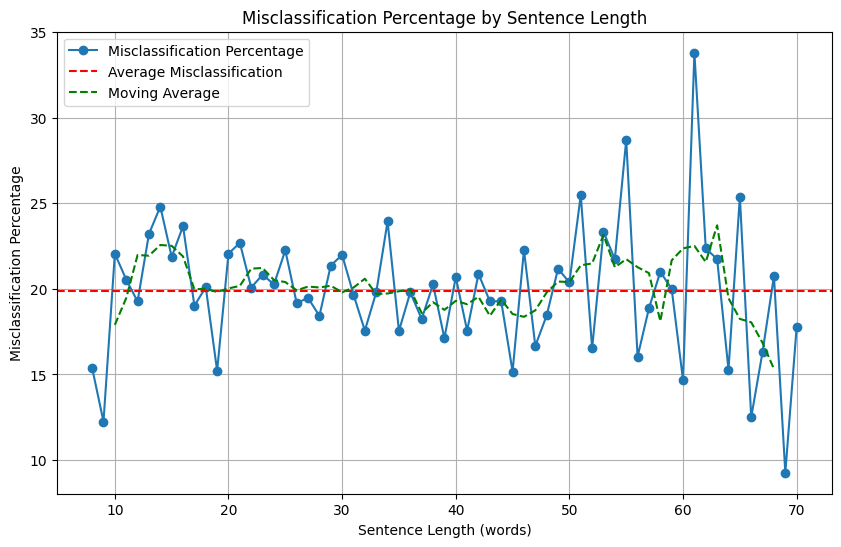

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store misclassified and total sentences for each length
misclassified_by_length = {}
total_by_length = {}

# Loop through all samples
for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 70 or description_words <8:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words] += 1
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = 1 if actual_label != predicted_label else 0
        total_by_length[description_words] = 1

# Calculate misclassification percentage for each length
misclassification_percentage_by_length = {}
for length, misclassified_count in misclassified_by_length.items():
    total_count = total_by_length[length]
    misclassification_percentage_by_length[length] = (misclassified_count / total_count) * 100 if total_count > 0 else 0

# Sort the lengths
sorted_lengths = sorted(misclassification_percentage_by_length.keys())

# Prepare data for plotting
lengths = [length for length in sorted_lengths]
misclassification_percentages = [misclassification_percentage_by_length[length] for length in sorted_lengths]

# Calculate average misclassification percentage
average_misclassification = np.mean(misclassification_percentages)

# Calculate moving average with window size 5
moving_average = np.convolve(misclassification_percentages, np.ones(5)/5, mode='same')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(lengths, misclassification_percentages, marker='o', linestyle='-', label='Misclassification Percentage')
plt.axhline(y=percentage_misclassified, color='red', linestyle='--', label='Average Misclassification')
plt.plot(lengths[2:-2], moving_average[2:-2], color='green', linestyle='--', label='Moving Average')
plt.title('Misclassification Percentage by Sentence Length')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Misclassification Percentage')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
misclassified_by_length = {}
total_by_length = {}

for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 70 words or less than 8 words
    if description_words > 70 or description_words < 8:
        continue
    
    # Check if the length is already recorded
    if description_words in misclassified_by_length:
        # Update misclassified count
        if actual_label != predicted_label:
            misclassified_by_length[description_words].append((description, actual_label, predicted_label))
        total_by_length[description_words] += 1
    else:
        # Initialize counts for the new length
        misclassified_by_length[description_words] = [(description, actual_label, predicted_label)] if actual_label != predicted_label else []
        total_by_length[description_words] = 1

# Print the misclassified label distribution based on word's length
for length, misclassified_samples in misclassified_by_length.items():
    total_count = total_by_length[length]
    print(f"Misclassified Samples with Description Length {length} Words:")
    for description, actual_label, predicted_label in misclassified_samples:
        print(f"Description: {description}")
        print(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}")
        print()
    print(f"Total Misclassified Samples: {len(misclassified_samples)}, Total Samples: {total_count}, Misclassification Rate: {len(misclassified_samples) / total_count:.2f}\n")


Misclassified Samples with Description Length 67 Words:
Description: Redmine before 1.3.2 does not properly restrict the use of a hash to provide values for a model's attributes, which allows remote attackers to set attributes in the (1) Comment, (2) Document, (3) IssueCategory, (4) MembersController, (5) Message, (6) News, (7) TimeEntry, (8) Version, (9) Wiki, (10) UserPreference, or (11) Board model via a modified URL, related to a "mass assignment" vulnerability, a different vulnerability than CVE-2012-0327.
Actual Label: 255, Predicted Label: 264

Description: Microsoft Edge in Microsoft Windows 10 1511, 1607, 1703, and Windows Server 2016 allows an attacker to execute arbitrary code in the context of the current user, due to the way that the scripting engine handles objects in memory in Microsoft Edge, aka "Scripting Engine Memory Corruption Vulnerability". This CVE ID is unique from CVE-2017-8649, CVE-2017-8649, CVE-2017-8660, CVE-2017-8729, CVE-2017-8738, CVE-2017-8740, CVE-2017

In [27]:
word_length_distribution = {}

for i, (sample, actual_label, predicted_label) in enumerate(zip(X_test, y_test, y_pred_original)):
    # Extract the description from the original data dictionary
    description = unbalanced[i]['cve_description']
    
    # Calculate description length in terms of words
    description_words = len(description.split())
    
    # Exclude sentences with more than 120 words
    if description_words > 80:
        continue

    # Update word length distribution
    if description_words in word_length_distribution:
        word_length_distribution[description_words] += 1
    else:
        word_length_distribution[description_words] = 1

# Print word length distribution
print("Word Length Distribution:")
for length, count in sorted(word_length_distribution.items()):
    print(f"Length {length}: {count} descriptions")


A potential use-after-free vulnerability existed in SVG Images if the Refresh Driver was destroyed at an inopportune time.  This could have lead to memory corruption or a potentially exploitable crash.
*Note*: This advisory was added on December 13th, 2022 after discovering it was inadvertently left out of the original advisory. The fix was included in the original release of Firefox 106. This vulnerability affects Firefox < 106.
['Use-after-Free Vulnerability', 'Memory Corruption', 'Exploitable Crash']
Adobe Substance 3D Painter versions 8.3.0 (and earlier) is affected by an out-of-bounds read vulnerability when parsing a crafted file, which could result in a read past the end of an allocated memory structure. An attacker could leverage this vulnerability to execute code in the context of the current user. Exploitation of this issue requires user interaction in that a victim must open a malicious file.
['Out-of-Bounds Read Vulnerability', 'Crafted File Parsing', 'Code Execution']
Redm

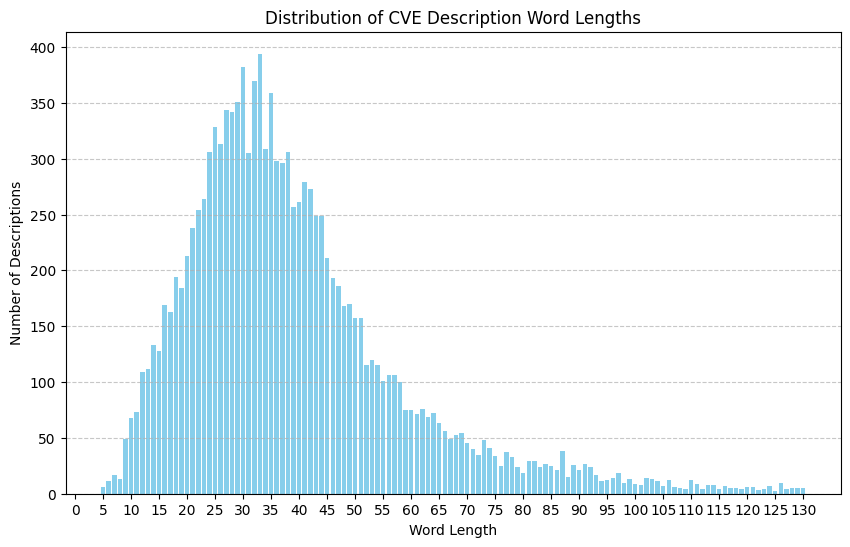

In [22]:
import matplotlib.pyplot as plt

# Convert word length distribution dictionary to lists for plotting
lengths, counts = zip(*sorted(word_length_distribution.items()))

# Plot word length distribution
plt.figure(figsize=(10, 6))
plt.bar(lengths, counts, color='skyblue')
plt.xlabel('Word Length')
plt.ylabel('Number of Descriptions')
plt.title('Distribution of CVE Description Word Lengths')
plt.xticks(range(0, max(lengths)+1, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
